In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
from iminuit import Minuit
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/'

SoFi_keys = ['Tinatinv4_2factor_profile', 'Tinatinv4_2factor_timeseries', 
             'KBHH2024v12_4factor_profile', 'KBHH2024v12_4factor_timeseries',
             'KBHH2024v15_5factor_profile', 'KBHH2024v15_5factor_timeseries']
Ref_keys = ['002_HOA', '011_HOA', '014_HOA', '003_OOA', '007_LO-OOA', '010_LO-OOA', '005_MO-OOA', '009_MO-OOA', '012_MO-OOA', '030_Birchen', '039_Oak', '041_Pinetree', '042_Poplar']
# 002_HOA is 001_HOA in database

SoFi = read_txt(f'{path}cph central and nørreport measurements/SoFi resultater/', parent_path, SoFi_keys, '\t', None)
for key in [key for key in SoFi_keys if 'timeseries' in key]:
    SoFi[key]['Time'] = pd.to_datetime(SoFi[key]['Time']) + pd.Timedelta(hours = 1)

    SoFi[key]['Date'] = SoFi[key]['Time'].dt.date
    for date in SoFi[key]['Date'].unique():
        mask = SoFi[key]['Date'] == date
        new_df = SoFi[key][mask].reset_index()
        name = key.split('_')[0]
        SoFi[f'{name}_{date}'] = new_df

Ref_MS = read_txt(f'{path}ref ms/txt files/', parent_path, Ref_keys, '\t', None)

ACSM = read_csv(f'{path}cph central and nørreport measurements/Station 1/Timeseries/', parent_path, 't_base', None, 1)

In [3]:
print(SoFi.keys())

dict_keys(['Tinatinv4_2factor_profile', 'Tinatinv4_2factor_timeseries', 'KBHH2024v12_4factor_profile', 'KBHH2024v12_4factor_timeseries', 'KBHH2024v15_5factor_profile', 'KBHH2024v15_5factor_timeseries', 'Tinatinv4_2022-03-08', 'KBHH2024v12_2024-12-10', 'KBHH2024v12_2024-12-11', 'KBHH2024v12_2024-12-12', 'KBHH2024v12_2024-12-13', 'KBHH2024v15_2024-12-10', 'KBHH2024v15_2024-12-11', 'KBHH2024v15_2024-12-12', 'KBHH2024v15_2024-12-13'])


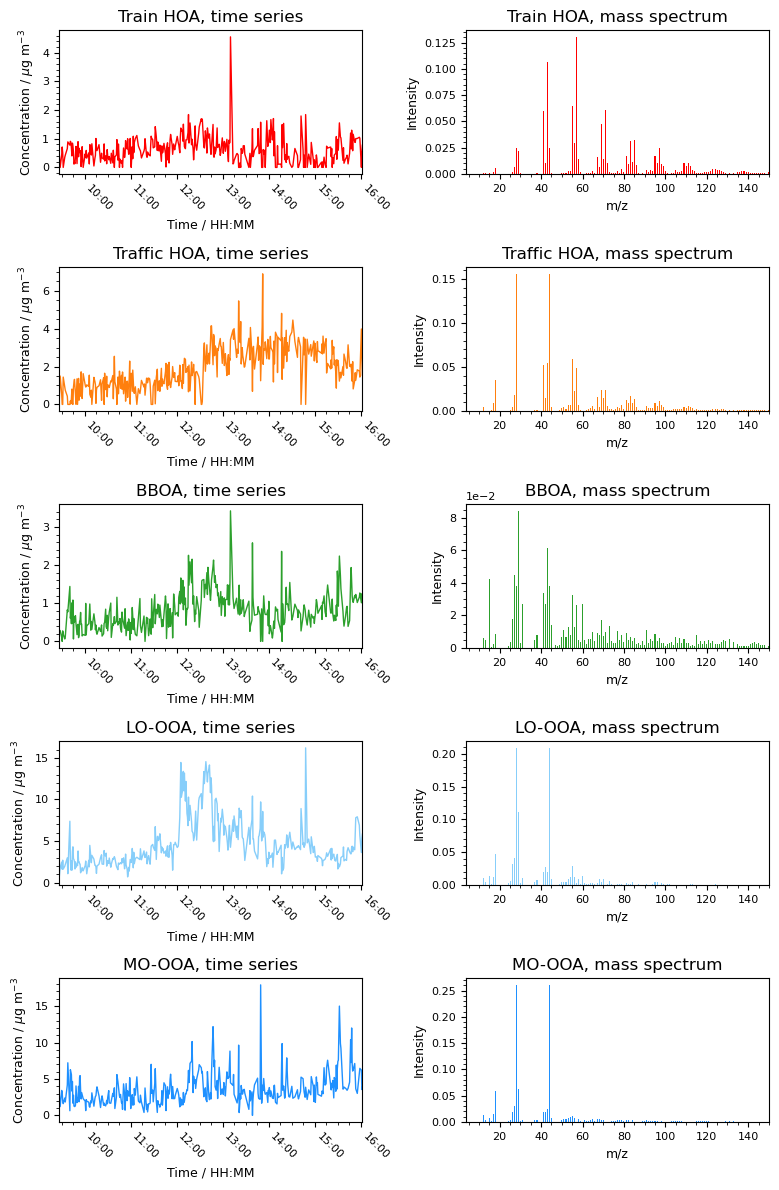

In [4]:
fig, ax = plt. subplots(5, 2, figsize = (8, 12))

colors = ['r', 'tab:orange', 'tab:green', 'lightskyblue', 'dodgerblue'] # Train HOA, Traffic HOA, BBOA, LO-OOA, MO-OOA
titles = ['Train HOA', 'Traffic HOA', 'BBOA', 'LO-OOA', 'MO-OOA']

for i in range(5):
    conc = f'Factor{i+1}'

    plot_total(ax[i][0], SoFi['KBHH2024v15_2024-12-11'], conc, colors[i], '-')
    ax[i][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = f'{titles[i]}, time series')
    plot_MS(ax[i][1], SoFi['KBHH2024v15_5factor_profile'], conc, 0.5, f'{titles[i]}, mass spectrum', colors[i])

fig.tight_layout()
fig.savefig('SoFi/KBHH2024v15_5factor_PMF.png', dpi = 600)
plt.show()

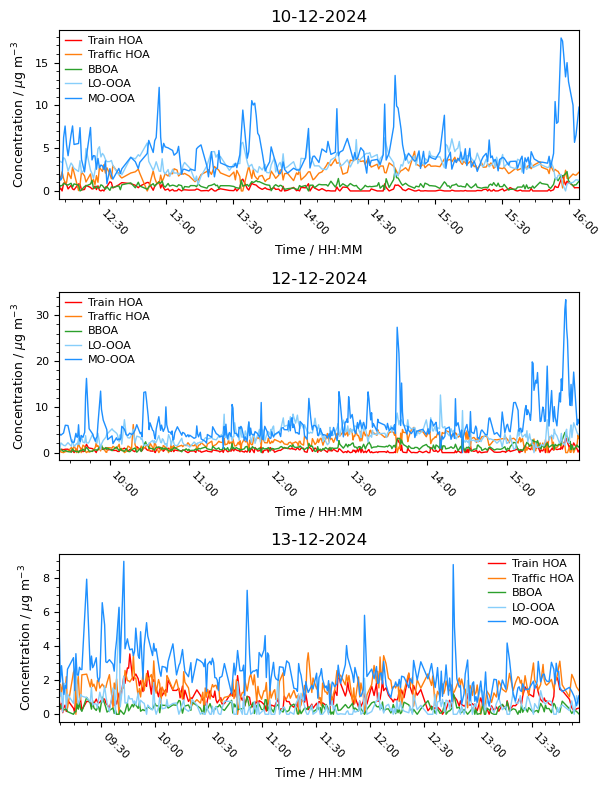

In [45]:
fig, ax = plt. subplots(3, 1, figsize = (6.3, 8))

colors = ['r', 'tab:orange', 'tab:green', 'lightskyblue', 'dodgerblue'] # Train HOA, Traffic HOA, BBOA, LO-OOA, MO-OOA
titles = ['Train HOA', 'Traffic HOA', 'BBOA', 'LO-OOA', 'MO-OOA']
dates = ['2024-12-10', '2024-12-12', '2024-12-13']

for i in range(3):
    for j in range(5):
        conc = f'Factor{j+1}'
        ttl = dates[i].split('-')

        plot_total(ax[i], SoFi[f'KBHH2024v15_{dates[i]}'], conc, colors[j], '-')
        ax[i].legend(labels = titles, fontsize = 8)
        ax[i].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = f'{ttl[2]}-{ttl[1]}-{ttl[0]}')

fig.tight_layout()
fig.savefig('SoFi/KBHH2024v15_5factor_PMF_timeseries.png', dpi = 600)
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (6.3, 6))

dates = ['2024-12-10', '2024-12-11', '2024-12-12', '2024-12-13']
for i, date in enumerate(dates):
    ACSM_date = date.split('-')
    ACSM_date = f'{ACSM_date[2]}-{ACSM_date[1]}-{ACSM_date[0]}'
    ACSM[ACSM_date]['Time'] = ACSM[ACSM_date].round('1s')
    merged = pd.merge(SoFi[f'KBHH2024v15_{date}'], ACSM[ACSM_date], on = 'Time')

    ax = axes.flatten()[i]

In [52]:
for date in ['2024-12-10', '2024-12-11', '2024-12-12', '2024-12-13']:
    ACSM_date = date.split('-')
    ACSM[f'{ACSM_date[2]}-{ACSM_date[1]}-{ACSM_date[0]}']['Time'] = ACSM[f'{ACSM_date[2]}-{ACSM_date[1]}-{ACSM_date[0]}']['Time'].round('1s')
    print(SoFi[f'KBHH2024v15_{date}']['Time'], ACSM[f'{ACSM_date[2]}-{ACSM_date[1]}-{ACSM_date[0]}']['Time'].round('1s'))
    merged = pd.merge(SoFi[f'KBHH2024v15_{date}'], ACSM[f'{ACSM_date[2]}-{ACSM_date[1]}-{ACSM_date[0]}'], on = 'Time')
    display(merged)
    # display(SoFi[f'KBHH2024v15_{date}'].iloc[:,2:7])

0     2024-12-10 12:12:12
1     2024-12-10 12:12:52
2     2024-12-10 12:13:32
3     2024-12-10 12:14:12
4     2024-12-10 12:14:52
              ...        
218   2024-12-10 15:59:48
219   2024-12-10 16:01:48
220   2024-12-10 16:02:28
221   2024-12-10 16:03:08
222   2024-12-10 16:04:28
Name: Time, Length: 223, dtype: datetime64[ns] 0     2024-12-10 11:41:31
1     2024-12-10 11:42:11
2     2024-12-10 11:42:51
3     2024-12-10 11:43:31
4     2024-12-10 11:44:11
              ...        
390   2024-12-10 16:01:48
391   2024-12-10 16:02:28
392   2024-12-10 16:03:08
393   2024-12-10 16:03:48
394   2024-12-10 16:04:29
Name: Time, Length: 395, dtype: datetime64[ns]


,index,Time,Factor1,Factor2,Factor3,Factor4,Factor5,Date,t_base,NH4,NO3,Chl,Org,SO4
0,0,2024-12-10 12:12:12,0.061045,1.834706,0.340117,3.574324,2.079808,2024-12-10,12/10/2024 11:12:12.395701,0.309422,0.564523,0.103606,8.276259,0.520636
1,1,2024-12-10 12:12:52,0.338415,1.418409,0.628691,3.399973,1.257767,2024-12-10,12/10/2024 11:12:52.427701,0.094515,0.778370,0.058873,7.259453,0.557215
2,2,2024-12-10 12:13:32,0.000000,2.230113,0.626400,3.325845,1.541629,2024-12-10,12/10/2024 11:13:32.459701,0.195392,0.813597,0.159940,7.243966,0.565375
3,3,2024-12-10 12:14:12,0.889049,1.447695,0.890382,3.887696,6.235882,2024-12-10,12/10/2024 11:14:12.491701,0.084804,1.160026,0.297950,13.968193,0.474061
4,15,2024-12-10 12:26:13,0.410827,1.980504,0.807996,2.413212,7.414435,2024-12-10,12/10/2024 11:26:13.067701,-0.148258,1.127143,0.389782,13.385628,0.650486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,217,2024-12-10 15:59:08,1.140829,1.468373,2.260811,0.787053,14.988682,2024-12-10,12/10/2024 14:59:08.266613,0.303483,1.665909,0.196595,21.226751,0.476300
113,218,2024-12-10 15:59:48,0.982271,1.424182,1.193717,0.905058,12.754763,2024-12-10,12/10/2024 14:59:48.298613,0.493149,1.408487,0.202354,18.004057,0.357140
114,219,2024-12-10 16:01:48,0.658711,1.981553,0.589199,1.000686,10.017219,2024-12-10,12/10/2024 15:01:48.394613,0.369423,1.451141,0.152055,14.927335,0.497952
115,220,2024-12-10 16:02:28,0.362518,1.880891,0.699856,1.150213,5.675934,2024-12-10,12/10/2024 15:02:28.426613,0.492645,1.188342,0.140680,10.281707,0.596194


0     2024-12-11 09:26:30
1     2024-12-11 09:27:50
2     2024-12-11 09:29:50
3     2024-12-11 09:30:30
4     2024-12-11 09:31:10
              ...        
356   2024-12-11 15:57:54
357   2024-12-11 15:58:34
358   2024-12-11 16:00:34
359   2024-12-11 16:01:14
360   2024-12-11 16:01:54
Name: Time, Length: 361, dtype: datetime64[ns] 0     2024-12-11 08:56:30
1     2024-12-11 08:57:10
2     2024-12-11 08:57:50
3     2024-12-11 08:58:30
4     2024-12-11 08:59:10
              ...        
635   2024-12-11 15:59:55
636   2024-12-11 16:00:35
637   2024-12-11 16:01:15
638   2024-12-11 16:01:55
639   2024-12-11 16:02:35
Name: Time, Length: 640, dtype: datetime64[ns]


,index,Time,Factor1,Factor2,Factor3,Factor4,Factor5,Date,t_base,NH4,NO3,Chl,Org,SO4
0,223,2024-12-11 09:26:30,0.558454,0.000000,0.221487,0.501879,3.185451,2024-12-11,12/11/2024 08:26:30.090251,0.204968,1.259754,0.135760,4.844811,0.635056
1,224,2024-12-11 09:27:50,0.000000,1.497554,0.285369,1.781597,1.204381,2024-12-11,12/11/2024 08:27:50.094478,0.845956,1.154217,0.125714,3.945836,0.526971
2,225,2024-12-11 09:29:50,0.430383,0.550842,0.110529,2.462862,3.425861,2024-12-11,12/11/2024 08:29:50.100817,0.082878,1.484078,0.059024,7.843052,0.560301
3,226,2024-12-11 09:30:30,0.712638,0.000000,0.000000,1.612164,3.172839,2024-12-11,12/11/2024 08:30:30.102931,0.078564,1.085495,0.141409,6.023157,0.580435
4,227,2024-12-11 09:31:10,0.509921,0.000000,0.275880,2.688941,1.944788,2024-12-11,12/11/2024 08:31:10.105044,0.413108,1.060237,0.092485,5.537462,0.529317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,454,2024-12-11 13:25:14,0.491915,2.998467,0.841325,5.479953,2.909537,2024-12-11,12/11/2024 12:25:14.474208,0.244527,1.051708,0.231744,12.790024,0.442000
154,455,2024-12-11 13:25:54,0.531129,2.580071,0.940504,5.332159,2.974067,2024-12-11,12/11/2024 12:25:54.476322,-0.682528,0.828504,0.286708,13.236650,0.450938
155,456,2024-12-11 13:26:34,0.754574,2.409816,1.091300,5.274888,3.504990,2024-12-11,12/11/2024 12:26:34.478435,0.096757,0.821862,0.450791,13.173063,0.475695
156,457,2024-12-11 13:27:54,0.756838,1.965598,0.652080,3.799942,3.575739,2024-12-11,12/11/2024 12:27:54.482662,-0.194430,0.667701,0.102270,11.380121,0.543721


0     2024-12-12 09:21:54
1     2024-12-12 09:23:14
2     2024-12-12 09:25:14
3     2024-12-12 09:26:34
4     2024-12-12 09:28:34
              ...        
356   2024-12-12 15:49:19
357   2024-12-12 15:50:39
358   2024-12-12 15:53:19
359   2024-12-12 15:53:59
360   2024-12-12 15:54:39
Name: Time, Length: 361, dtype: datetime64[ns] 0     2024-12-12 08:50:34
1     2024-12-12 08:51:14
2     2024-12-12 08:51:54
3     2024-12-12 08:52:34
4     2024-12-12 08:53:14
              ...        
632   2024-12-12 15:51:59
633   2024-12-12 15:52:39
634   2024-12-12 15:53:19
635   2024-12-12 15:53:59
636   2024-12-12 15:54:39
Name: Time, Length: 637, dtype: datetime64[ns]


,index,Time,Factor1,Factor2,Factor3,Factor4,Factor5,Date,t_base,NH4,NO3,Chl,Org,SO4
0,711,2024-12-12 11:46:35,0.500347,1.949119,0.762705,2.882691,5.362356,2024-12-12,12/12/2024 10:46:35.0021,0.316165,1.260182,0.256698,12.228752,0.487580
1,712,2024-12-12 11:47:15,0.982393,1.733098,0.845510,2.241054,4.136724,2024-12-12,12/12/2024 10:47:15.004212,0.517135,1.493025,0.163126,9.965422,0.485381
2,713,2024-12-12 11:47:55,0.658559,1.716199,1.321523,3.426530,3.926031,2024-12-12,12/12/2024 10:47:55.006326,-0.091069,1.097914,0.254711,11.579639,0.449770
3,714,2024-12-12 11:49:15,0.000000,3.501255,0.965269,4.122782,3.845174,2024-12-12,12/12/2024 10:49:15.010552,0.138963,1.142297,0.031123,11.727024,0.354162
4,715,2024-12-12 11:49:55,1.112892,2.582170,0.970755,2.026313,4.610373,2024-12-12,12/12/2024 10:49:55.012666,0.876977,1.500065,0.171258,11.475934,0.467295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,940,2024-12-12 15:49:19,0.951448,1.424182,1.637918,3.312219,10.268599,2024-12-12,12/12/2024 14:49:19.389857,0.805679,2.567542,0.298630,17.912151,0.323321
176,941,2024-12-12 15:50:39,2.116380,0.000000,0.633888,6.533222,17.604422,2024-12-12,12/12/2024 14:50:39.394083,0.924018,2.670803,0.833093,28.821758,0.376170
177,942,2024-12-12 15:53:19,0.729686,2.002651,1.657497,4.292053,6.021129,2024-12-12,12/12/2024 14:53:19.402536,-0.591573,1.427983,0.252073,14.654118,0.212044
178,943,2024-12-12 15:53:59,0.121475,3.918181,1.212436,4.052117,7.286153,2024-12-12,12/12/2024 14:53:59.40465,0.594333,1.433199,0.284486,16.369137,0.303988


0     2024-12-13 09:06:54
1     2024-12-13 09:07:34
2     2024-12-13 09:08:14
3     2024-12-13 09:08:54
4     2024-12-13 09:09:34
              ...        
273   2024-12-13 13:50:59
274   2024-12-13 13:52:19
275   2024-12-13 13:53:39
276   2024-12-13 13:54:59
277   2024-12-13 13:56:19
Name: Time, Length: 278, dtype: datetime64[ns] 0     2024-12-13 08:39:35
1     2024-12-13 08:40:15
2     2024-12-13 08:40:55
3     2024-12-13 08:41:35
4     2024-12-13 08:42:15
              ...        
472   2024-12-13 13:54:19
473   2024-12-13 13:54:59
474   2024-12-13 13:55:39
475   2024-12-13 13:56:19
476   2024-12-13 13:56:59
Name: Time, Length: 477, dtype: datetime64[ns]


,index,Time,Factor1,Factor2,Factor3,Factor4,Factor5,Date,t_base,NH4,NO3,Chl,Org,SO4
0,979,2024-12-13 09:40:15,1.250843,0.000000,0.000000,6.198836,6.303349,2024-12-13,12/13/2024 08:40:15.00027,1.196940,4.404586,0.174599,16.942717,0.334949
1,980,2024-12-13 09:40:55,0.752025,1.335381,0.247823,0.442276,3.030044,2024-12-13,12/13/2024 08:40:55.002383,1.331296,2.916998,0.340983,6.135643,0.411022
2,981,2024-12-13 09:42:55,2.229658,1.588140,0.000000,2.243756,9.009968,2024-12-13,12/13/2024 08:42:55.008723,0.752334,3.199116,0.173132,15.893871,0.433684
3,982,2024-12-13 09:43:35,1.822838,2.584899,0.140457,0.666139,3.858392,2024-12-13,12/13/2024 08:43:35.010836,1.234515,3.487010,0.099169,8.119840,0.403921
4,983,2024-12-13 09:44:55,2.732931,1.980294,0.670013,0.669972,4.444687,2024-12-13,12/13/2024 08:44:55.015063,1.616392,3.708537,0.118548,10.762015,0.374512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,1218,2024-12-13 13:50:59,0.888029,1.023243,0.327487,0.217953,1.586204,2024-12-13,12/13/2024 12:50:59.312102,0.664259,0.668546,0.300936,3.830348,0.959664
226,1219,2024-12-13 13:52:19,0.387468,2.350090,0.047873,0.793265,1.345794,2024-12-13,12/13/2024 12:52:19.316329,0.536121,0.920005,0.037855,4.858744,0.889740
227,1220,2024-12-13 13:53:39,0.167673,2.026584,0.262992,0.000000,1.041373,2024-12-13,12/13/2024 12:53:39.320555,0.904495,1.045732,0.115665,2.750241,0.881147
228,1221,2024-12-13 13:54:59,0.328637,1.600106,0.164652,1.093012,0.503012,2024-12-13,12/13/2024 12:54:59.324781,0.597303,0.603211,0.116518,3.801827,0.957808


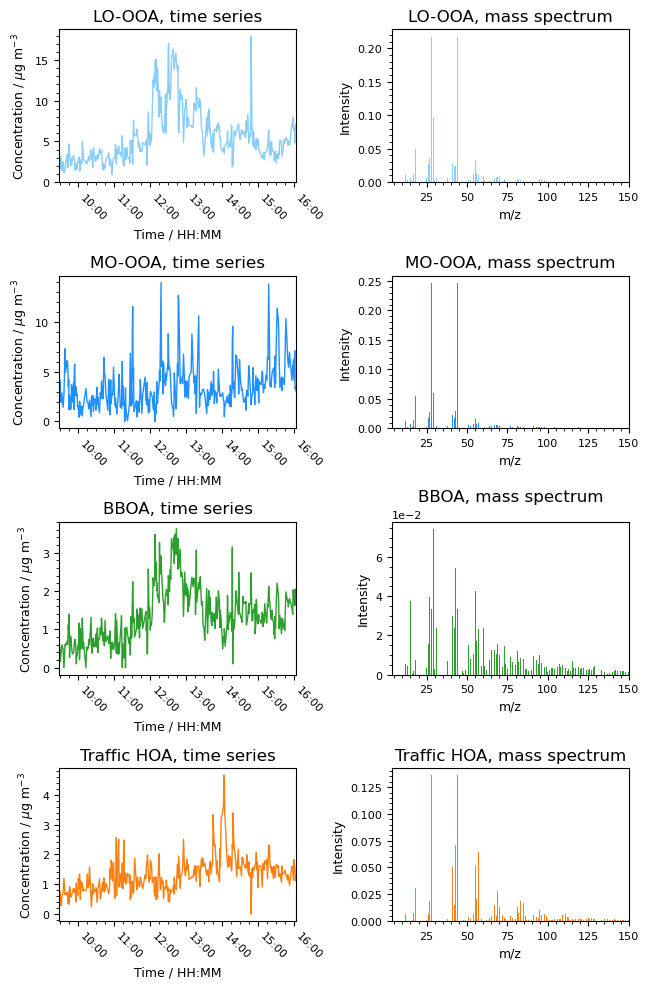

In [46]:
fig, ax = plt. subplots(4, 2, figsize = (6.7, 10))

colors = ['lightskyblue', 'dodgerblue', 'tab:green', 'tab:orange'] # Train HOA, Traffic HOA, BBOA, LO-OOA, MO-OOA
titles = ['LO-OOA', 'MO-OOA', 'BBOA', 'Traffic HOA']

for i in range(4):
    conc = f'Factor{i+1}'

    plot_total(ax[i][0], SoFi['KBHH2024v12_2024-12-11'], conc, colors[i], '-')
    ax[i][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = f'{titles[i]}, time series')
    plot_MS(ax[i][1], SoFi['KBHH2024v12_4factor_profile'], conc, 0.5, f'{titles[i]}, mass spectrum', colors[i])

fig.tight_layout()
fig.savefig('SoFi/KBHH2024v12_4factor_PMF.png', dpi = 600)
plt.show()

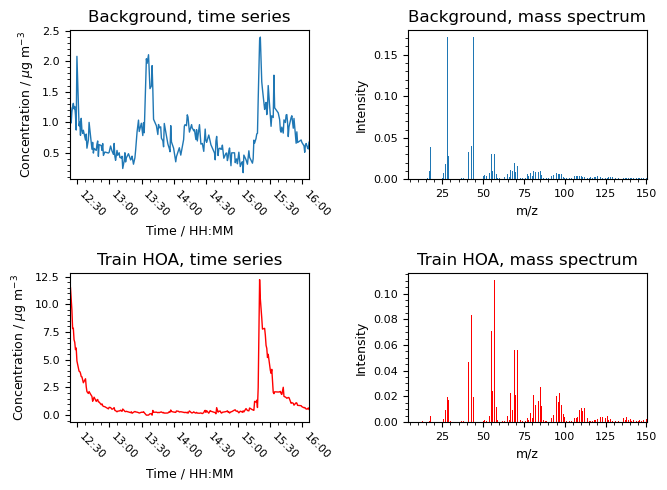

In [6]:
fig, ax = plt.subplots(2, 2, figsize = (6.7, 5))

plot_total(ax[0][0], SoFi['Tinatinv4_2022-03-08'], 'background', 'tab:blue', '-')
ax[0][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = 'Background, time series')
plot_MS(ax[0][1], SoFi['Tinatinv4_2factor_profile'], 'background', 0.5, 'Background, mass spectrum', 'tab:blue')

plot_total(ax[1][0], SoFi['Tinatinv4_2022-03-08'], 'train HOA', 'r', '-')
ax[1][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = 'Train HOA, time series')
plot_MS(ax[1][1], SoFi['Tinatinv4_2factor_profile'], 'train HOA', 0.5, 'Train HOA, mass spectrum', 'r')

fig.tight_layout()
fig.savefig('SoFi/Tinatin_PMF.png', dpi = 600)
plt.show()

In [7]:
def PMF_MS_validation(axes, PMF_df, PMF_key, Ref_dict, Ref_dict_keys, Ref_df_keys, markers, marker_colors):
    for i, key in enumerate(Ref_dict_keys):
        merged = pd.merge(PMF_df, Ref_dict[key], on = 'm/z')
        PMF_total_int, Ref_total_int = pd.to_numeric(merged[PMF_key], errors = 'coerce').sum(), pd.to_numeric(merged[Ref_df_keys[i]], errors = 'coerce').sum()
        merged['PMF scaled'] = pd.to_numeric(merged[PMF_key], errors = 'coerce') / PMF_total_int
        merged['Ref scaled'] = pd.to_numeric(merged[Ref_df_keys[i]], errors = 'coerce') / Ref_total_int

        max_PMF, max_Ref = max(merged['PMF scaled']), max(merged['Ref scaled'])
        if max_PMF > max_Ref:
            x_plot = np.linspace(0, max_PMF + 0.1*max_PMF, 200)
        else:
            x_plot = np.linspace(0, max_Ref + 0.1*max_Ref, 200)
        axes[i].plot(x_plot, x_plot, color = 'grey', lw = 1, ls = '--')

        fit_params, fit_errors, Ndof_fit, squares_fit, R2 = linear_fit(merged['PMF scaled'], merged['Ref scaled'], linear, a_guess = 1, b_guess = 0)
        y_fit = linear(x_plot, *fit_params)

        axes[i].plot(x_plot, y_fit, label = 'Fit', color = 'k', lw = 1.2)
        axes[i].scatter(merged['PMF scaled'], merged['Ref scaled'], s = 10, c = 'blue', label = None)

        for idx, row in merged.iterrows():
            for color, marker in zip(marker_colors, markers):
                if marker == row['m/z']:
                    axes[i].scatter(row['PMF scaled'], row['Ref scaled'], color = color, s = 15)

        axes[i].legend()

        print(f'{key}: ({fit_params[0]:.3f} +- {fit_errors[0]:.4f})x + ({fit_params[1]:.3f} +- {fit_errors[1]:.4f}), R2 = {R2}')

    return axes

In [8]:
HOA_markers = [41, 43, 55, 57]
BBOA_markers = [60, 73]
OOA_markers = [29, 30, 31]
marker_colors = ['orange', 'forestgreen', 'tab:red', 'deepskyblue']

002_HOA: (0.532 +- 5.4088)x + (0.003 +- 0.0903), R2 = 0.2156361972902708
011_HOA: (0.223 +- 5.4090)x + (0.008 +- 0.1130), R2 = 0.016613234774652104
014_HOA: (0.678 +- 5.4088)x + (0.002 +- 0.0903), R2 = 0.4638082096190963


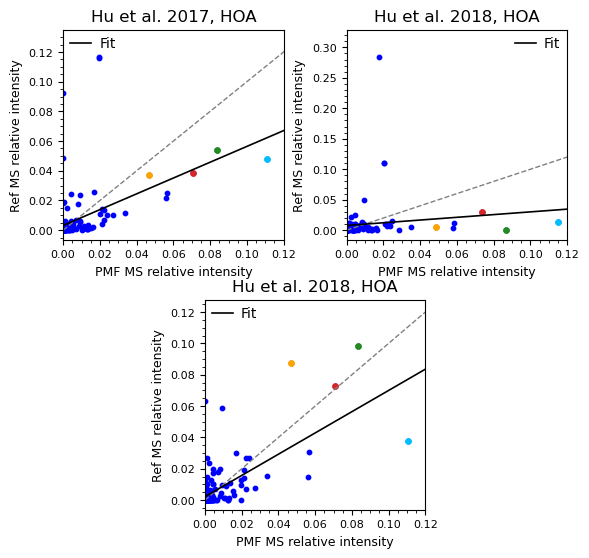

In [16]:
fig = plt.figure(figsize=(6.3, 6))
# Top-left subplot
ax1 = fig.add_axes([0.1, 0.55, 0.35, 0.35])  # [left, bottom, width, height]
# Top-right subplot
ax2 = fig.add_axes([0.55, 0.55, 0.35, 0.35])
# Bottom-center subplot (same size as above, centered)
ax3 = fig.add_axes([0.325, 0.1, 0.35, 0.35])
axes = np.array([ax1, ax2, ax3])

Ref_df_keys = ['HOA_total (002)', 'Intensity (011)', 'HOA total (014)']

titles = ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2018, HOA']

PMF_MS_validation(axes, SoFi['Tinatinv4_2factor_profile'], 'train HOA', Ref_MS, Ref_keys[:3], Ref_df_keys, HOA_markers, marker_colors)

for ax, ttl in zip(axes, titles):
    ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity', xlim = (0, 0.12))

fig.tight_layout()
fig.savefig('SoFi/PMF_tinatin_trainHOAvsRef.png', dpi = 600)
plt.show()

002_HOA: (0.711 +- 4.0250)x + (0.002 +- 0.0869), R2 = 0.6954135811252389
011_HOA: (0.679 +- 3.9562)x + (0.003 +- 0.1069), R2 = 0.28653740500398284
014_HOA: (0.182 +- 4.0250)x + (0.006 +- 0.0869), R2 = 0.06050095706692031
003_OOA: (1.170 +- 4.0250)x + (-0.001 +- 0.0869), R2 = 0.8325132079643123
007_LO-OOA: (1.181 +- 3.9235)x + (-0.002 +- 0.1113), R2 = 0.9262021932043114
010_LO-OOA: (1.610 +- 3.9562)x + (-0.006 +- 0.1069), R2 = 0.9372001195110674


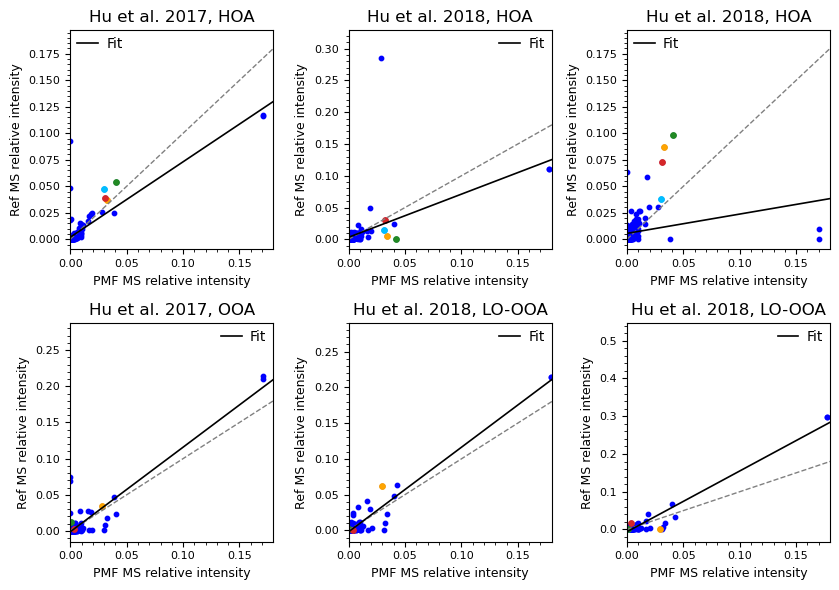

In [10]:
fig, axes = plt.subplots(2, 3, figsize = (8.5, 6))

Ref_df_keys_HOA = ['HOA_total (002)', 'Intensity (011)', 'HOA total (014)']
Ref_df_keys_LOOOA = ['OOA total (003)', 'Intensity (007)', 'Intensity (010)']

titles = ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2017, OOA', 'Hu et al. 2018, LO-OOA', 'Hu et al. 2018, LO-OOA']

PMF_MS_validation(axes[0], SoFi['Tinatinv4_2factor_profile'], 'background', Ref_MS, Ref_keys[:3], Ref_df_keys_HOA, HOA_markers, marker_colors)
PMF_MS_validation(axes[1], SoFi['Tinatinv4_2factor_profile'], 'background', Ref_MS, Ref_keys[3:6], Ref_df_keys_LOOOA, OOA_markers, marker_colors[:3])

for ax, ttl in zip(axes.flatten(), titles):
    ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity', xlim = (0, 0.18))

fig.tight_layout()
fig.savefig('SoFi/PMF_tinatin_BGvsRef.png', dpi = 600)
plt.show()

002_HOA: (0.502 +- 4.8157)x + (0.003 +- 0.0887), R2 = 0.24203946512856586
011_HOA: (0.227 +- 4.8048)x + (0.008 +- 0.1103), R2 = 0.021820673292958493
014_HOA: (0.609 +- 4.8157)x + (0.003 +- 0.0887), R2 = 0.47143601460156226


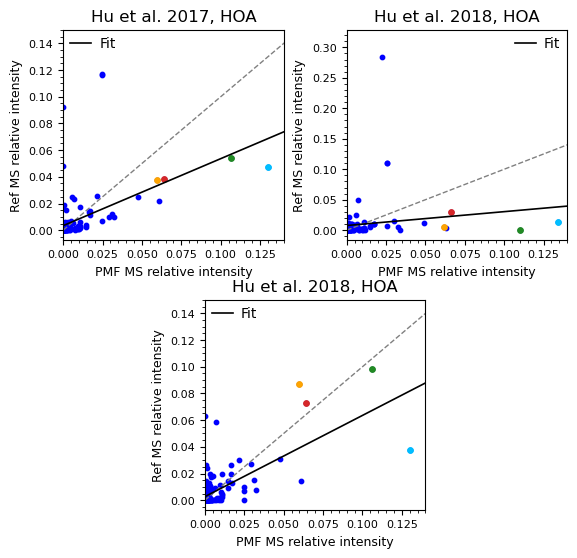

002_HOA: (0.738 +- 4.1193)x + (0.002 +- 0.0871), R2 = 0.7145077478162914
011_HOA: (0.549 +- 4.1224)x + (0.004 +- 0.1075), R2 = 0.172509148394275
014_HOA: (0.282 +- 4.1193)x + (0.005 +- 0.0871), R2 = 0.13826602260527057


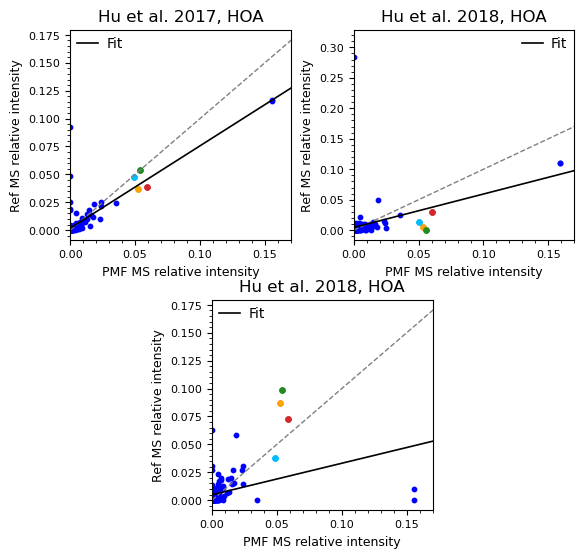

030_Birchen: (1.012 +- 7.3713)x + (0.000 +- 0.1071), R2 = 0.8899718726608129
039_Oak: (1.306 +- 7.3713)x + (-0.002 +- 0.1071), R2 = 0.8086543975233051
041_Pinetree: (1.184 +- 7.3713)x + (-0.001 +- 0.1071), R2 = 0.9052911287420952
042_Poplar: (1.065 +- 7.3713)x + (0.000 +- 0.1071), R2 = 0.8443816342894814


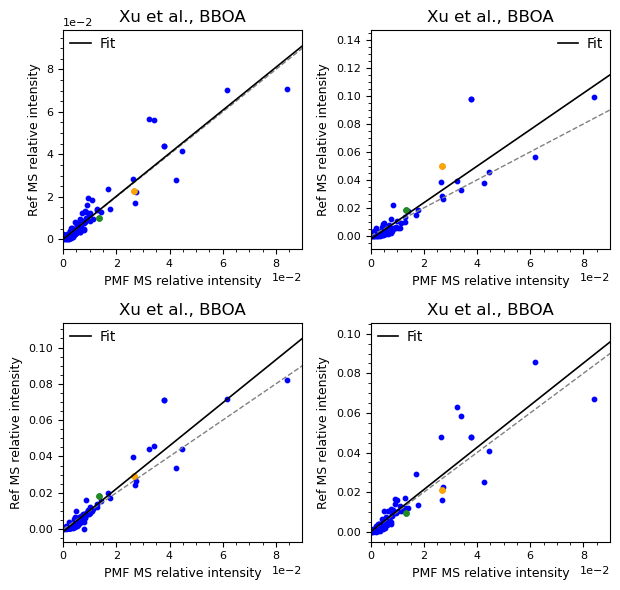

003_OOA: (0.913 +- 3.1325)x + (0.000 +- 0.0852), R2 = 0.8265609018864053
007_LO-OOA: (0.967 +- 3.1799)x + (0.000 +- 0.1085), R2 = 0.9377354145135779
010_LO-OOA: (1.236 +- 3.1733)x + (-0.002 +- 0.1043), R2 = 0.8583295132804674


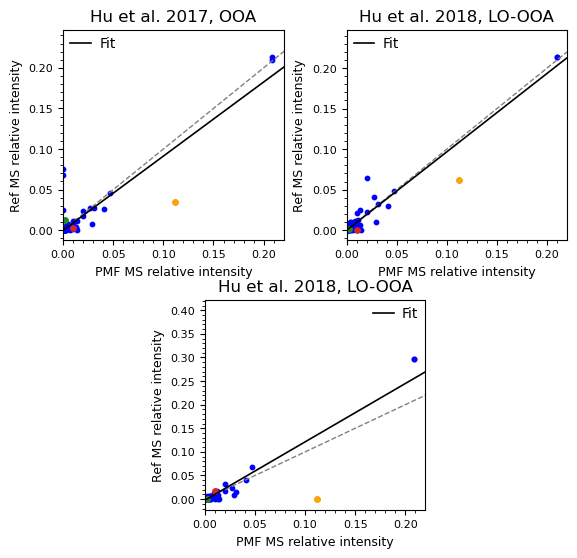

005_MO-OOA: (1.085 +- 2.6649)x + (-0.000 +- 0.1070), R2 = 0.9849819058254855
009_MO-OOA: (1.067 +- 2.6666)x + (-0.000 +- 0.1029), R2 = 0.9909400352467485
012_MO-OOA: (1.053 +- 2.6719)x + (-0.000 +- 0.0845), R2 = 0.9665957448479348


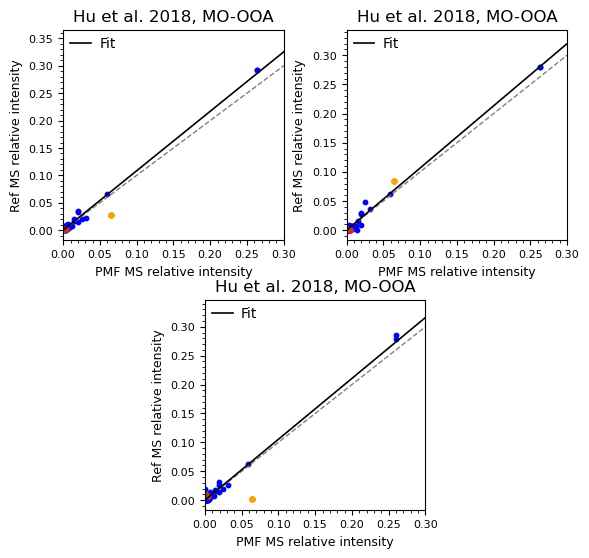

In [21]:
Ref_keys_5factor = [Ref_keys[:3], Ref_keys[:3], Ref_keys[9:], Ref_keys[3:6], Ref_keys[6:9]]
Factors = ['Train HOA', 'Traffic HOA', 'BBOA', 'LO-OOA', 'MO-OOA']
titles = [['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2018, HOA'],
          ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2018, HOA'],
          ['Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA'],
          ['Hu et al. 2017, OOA', 'Hu et al. 2018, LO-OOA', 'Hu et al. 2018, LO-OOA'],
          ['Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA']]
Ref_df_keys = [['HOA_total (002)', 'Intensity (011)', 'HOA total (014)'],
               ['HOA_total (002)', 'Intensity (011)', 'HOA total (014)'],
               ['Intensity (030)', 'Intensity (039)', 'Intensity (041)', 'Intensity (042)'],
               ['OOA total (003)', 'Intensity (007)', 'Intensity (010)'],
               ['Intensity (005)', 'Intensity (009)', 'MO-OOA total (012)']]
markers = [[41, 43, 55, 57], # HOA
           [41, 43, 55, 57], # HOA
           [60, 73],         # BBOA
           [29, 30, 31],     # LO-OOA
           [29, 30, 31]]     # MO-OOA

marker_colors = ['orange', 'forestgreen', 'tab:red', 'deepskyblue']
x_max = [0.14, 0.17, 0.09, 0.22, 0.3]

for i in range(5):
    if len(Ref_df_keys[i]) == 3:
        fig = plt.figure(figsize=(6.3, 6))
        # Top-left subplot
        ax1 = fig.add_axes([0.1, 0.55, 0.35, 0.35])  # [left, bottom, width, height]
        # Top-right subplot
        ax2 = fig.add_axes([0.55, 0.55, 0.35, 0.35])
        # Bottom-center subplot (same size as above, centered)
        ax3 = fig.add_axes([0.325, 0.1, 0.35, 0.35])
        axes = np.array([ax1, ax2, ax3])
    if len(Ref_df_keys[i]) == 4:
        fig, axes = plt.subplots(2, 2, figsize = (6.3, 6))

    factor = f'Factor{i+1}'

    PMF_MS_validation(axes.flatten(), SoFi['KBHH2024v15_5factor_profile'], factor, Ref_MS, Ref_keys_5factor[i], Ref_df_keys[i], markers[i], marker_colors[:len(markers[i])])

    for ax, ttl in zip(axes.flatten(), titles[i]):
        ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity', xlim = (0, x_max[i]))

    fig.tight_layout()
    fig.savefig(f'SoFi/PMF_KBHH2024v15_{Factors[i]}vsRef.png', dpi = 600)
    plt.show()

In [32]:
PMF_5factor_scaled = pd.DataFrame({'m/z': SoFi['KBHH2024v15_5factor_profile']['m/z']})
for i in range(5):
    factor = f'Factor{i+1}'
    total_int = pd.to_numeric(SoFi['KBHH2024v15_5factor_profile'][factor], errors = 'coerce').sum()
    PMF_5factor_scaled[factor] = pd.to_numeric(SoFi['KBHH2024v15_5factor_profile'][factor], errors = 'coerce') / total_int

Train_HOA = []
Traffic_HOA = []
BBOA = []
LO_OOA = []
MO_OOA = []
for idx, row in PMF_5factor_scaled.iterrows():
    for marker in [29, 30, 31, 41, 43, 44, 55, 57, 60, 73]:
        if marker == row['m/z']:
            Train_HOA.append(row['Factor1'])
            Traffic_HOA.append(row['Factor2'])
            BBOA.append(row['Factor3'])
            LO_OOA.append(row['Factor4'])
            MO_OOA.append(row['Factor5'])

# HOA
train_4143, traffic_4143 = Train_HOA[3]/Train_HOA[4], Traffic_HOA[3]/Traffic_HOA[4]
train_5557, traffic_5557 = Train_HOA[6]/Train_HOA[7], Traffic_HOA[6]/Traffic_HOA[7]
print(f'Train HOA: f41/f43 = {train_4143:.3f}, f55/f57 = {train_5557:.3f}')
print(f'Traffic HOA: f41/f43 = {traffic_4143:.3f}, f55/f57 = {traffic_5557:.3f}')
# BBOA
bboa_6073 = BBOA[8]/BBOA[9]
print(f'BBOA: f60/f73 = {bboa_6073:.3f}')
# OOA
LO_4443, MO_4443 = LO_OOA[5]/LO_OOA[6], MO_OOA[5]/MO_OOA[6]
print(f'f44/f43: LO-OOA = {LO_4443:.3f}, MO-OOA = {MO_4443:.3f}')
# LO-OOA vs. MO-OOA
LO_MO = np.array(LO_OOA[:3])/np.array(MO_OOA[:3])
print(f'LO-OOA vs. MO-OOA: f29 = {LO_MO[0]:.3f}, f30 = {LO_MO[1]:.3f}, f31 = {LO_MO[2]}')
# BBOA vs. other factors
BBOA_Train = np.array(BBOA[8:])/np.array(Train_HOA[8:])
BBOA_Traffic = np.array(BBOA[8:])/np.array(Traffic_HOA[8:])
BBOA_LO = np.array(BBOA[8:])/np.array(LO_OOA[8:])
BBOA_MO = np.array(BBOA[8:])/np.array(MO_OOA[8:])
print(f'BBOA vs Train HOA: f60 = {BBOA_Train[0]:.3f}, f73 = {BBOA_Train[1]:.3f}')
print(f'BBOA vs Traffic HOA: f60 = {BBOA_Traffic[0]:.3f}, f73 = {BBOA_Traffic[1]:.3f}')
print(f'BBOA vs LO-OOA: f60 = {BBOA_LO[0]:.3f}, f73 = {BBOA_LO[1]:.3f}')
print(f'BBOA vs MO-OOA: f60 = {BBOA_MO[0]:.3f}, f73 = {BBOA_MO[1]:.3f}')

Train HOA: f41/f43 = 0.559, f55/f57 = 0.494
Traffic HOA: f41/f43 = 0.969, f55/f57 = 1.205
BBOA: f60/f73 = 2.010
f44/f43: LO-OOA = 7.173, MO-OOA = 21.449
LO-OOA vs. MO-OOA: f29 = 1.764, f30 = 1.878, f31 = 2.5140426170678194
BBOA vs Train HOA: f60 = 127.419, f73 = 8.799
BBOA vs Traffic HOA: f60 = inf, f73 = 4.815
BBOA vs LO-OOA: f60 = 1.913, f73 = 2.067
BBOA vs MO-OOA: f60 = inf, f73 = 19.573


003_OOA: (0.906 +- 3.0694)x + (0.000 +- 0.0851), R2 = 0.8484259677877216
007_LO-OOA: (0.954 +- 3.1094)x + (-0.000 +- 0.1083), R2 = 0.9516400740327725
010_LO-OOA: (1.235 +- 3.1045)x + (-0.002 +- 0.1041), R2 = 0.8960554102621795


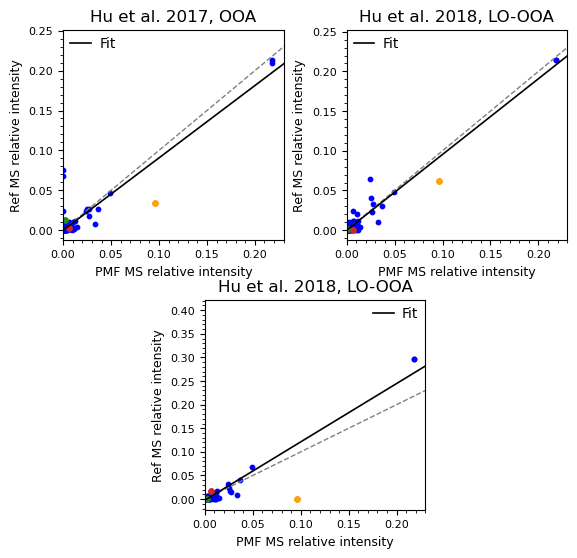

005_MO-OOA: (1.145 +- 2.8011)x + (-0.002 +- 0.1074), R2 = 0.9825300851480013
009_MO-OOA: (1.127 +- 2.8057)x + (-0.001 +- 0.1033), R2 = 0.9914977619276082
012_MO-OOA: (1.106 +- 2.8162)x + (-0.000 +- 0.0847), R2 = 0.9642498273643562


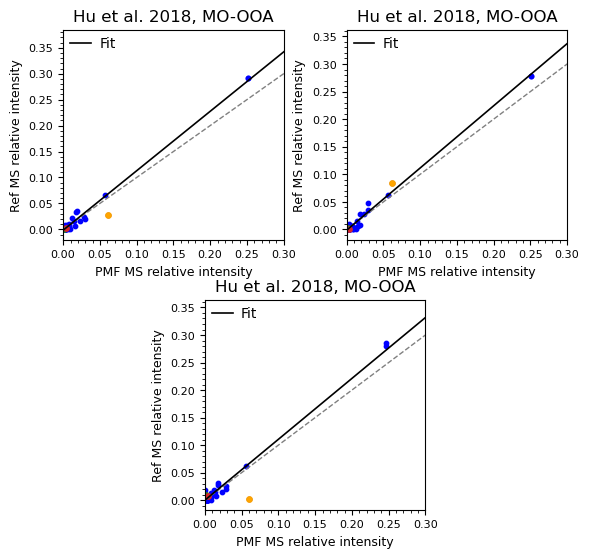

030_Birchen: (1.086 +- 8.1023)x + (0.000 +- 0.1105), R2 = 0.9096954447439718
039_Oak: (1.407 +- 8.1023)x + (-0.003 +- 0.1105), R2 = 0.7774629792097513
041_Pinetree: (1.291 +- 8.1023)x + (-0.002 +- 0.1105), R2 = 0.8911248779658839
042_Poplar: (1.219 +- 8.1023)x + (-0.002 +- 0.1105), R2 = 0.8698623446424018


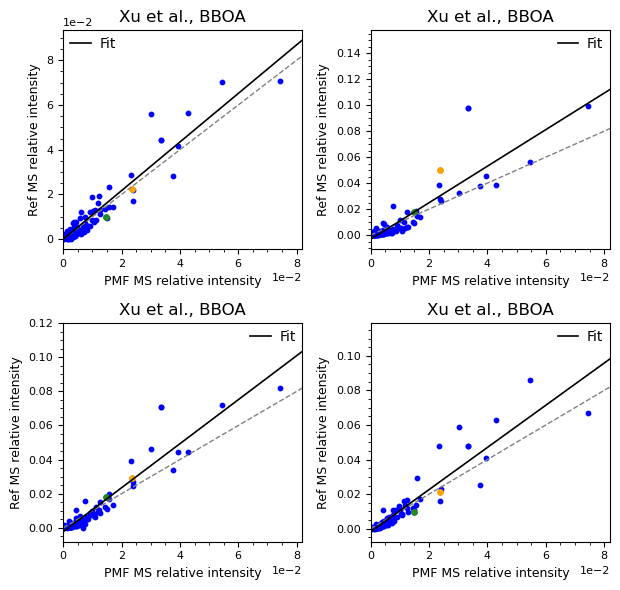

002_HOA: (0.796 +- 4.4374)x + (0.001 +- 0.0878), R2 = 0.7170432893508512
011_HOA: (0.551 +- 4.4392)x + (0.004 +- 0.1088), R2 = 0.15022470646583455
014_HOA: (0.357 +- 4.4374)x + (0.004 +- 0.0878), R2 = 0.19126196382450542


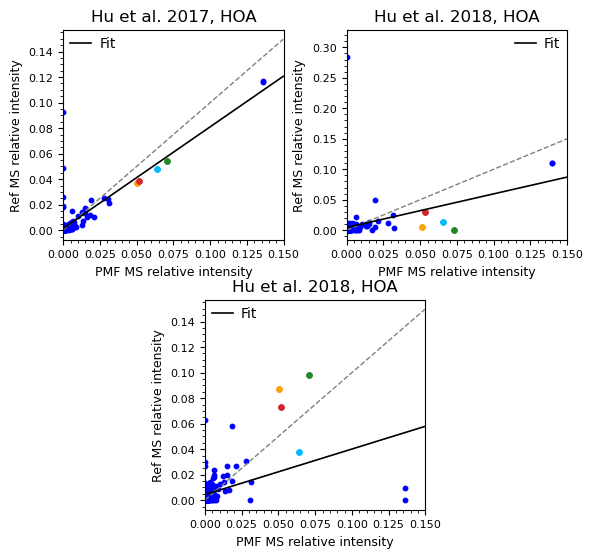

In [25]:
Ref_keys_4factor = [Ref_keys[3:6], Ref_keys[6:9], Ref_keys[9:], Ref_keys[:3]]
Factors = ['LO-OOA', 'MO-OOA', 'BBOA', 'Traffic HOA']
titles = [['Hu et al. 2017, OOA', 'Hu et al. 2018, LO-OOA', 'Hu et al. 2018, LO-OOA'],
          ['Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA'],
          ['Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA'],
          ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2018, HOA']]
Ref_df_keys = [['OOA total (003)', 'Intensity (007)', 'Intensity (010)'],
               ['Intensity (005)', 'Intensity (009)', 'MO-OOA total (012)'],
               ['Intensity (030)', 'Intensity (039)', 'Intensity (041)', 'Intensity (042)'],
               ['HOA_total (002)', 'Intensity (011)', 'HOA total (014)']]
markers = [[29, 30, 31],     # LO-OOA
           [29, 30, 31],     # MO-OOA
           [60, 73],         # BBOA
           [41, 43, 55, 57]] # HOA
           

marker_colors = ['orange', 'forestgreen', 'tab:red', 'deepskyblue']
x_max = [0.23, 0.3, 0.082, 0.15]

for i in range(4):
    if len(Ref_df_keys[i]) == 3:
        fig = plt.figure(figsize=(6.3, 6))
        # Top-left subplot
        ax1 = fig.add_axes([0.1, 0.55, 0.35, 0.35])  # [left, bottom, width, height]
        # Top-right subplot
        ax2 = fig.add_axes([0.55, 0.55, 0.35, 0.35])
        # Bottom-center subplot (same size as above, centered)
        ax3 = fig.add_axes([0.325, 0.1, 0.35, 0.35])
        axes = np.array([ax1, ax2, ax3])
    if len(Ref_df_keys[i]) == 4:
        fig, axes = plt.subplots(2, 2, figsize = (6.3, 6))

    factor = f'Factor{i+1}'

    PMF_MS_validation(axes.flatten(), SoFi['KBHH2024v12_4factor_profile'], factor, Ref_MS, Ref_keys_4factor[i], Ref_df_keys[i], markers[i], marker_colors[:len(markers[i])])

    for ax, ttl in zip(axes.flatten(), titles[i]):
        ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity', xlim = (0, x_max[i]))

    fig.tight_layout()
    fig.savefig(f'SoFi/PMF_KBHH2024v12_{Factors[i]}vsRef.png', dpi = 600)
    plt.show()